### Generate Images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

# Create directories
os.makedirs('target_images', exist_ok=True)
os.makedirs('input_images', exist_ok=True)
os.makedirs('org_images', exist_ok=True)  # New folder for original ellipses

# Parameters
num_images = 1000
width, height = 32, 32

# Generate random parameters
np.random.seed(42)
a_params = np.random.uniform(0.5, 0.9, num_images)
b_params = np.random.uniform(0.3, 0.7, num_images)
x_offsets = np.random.uniform(-0.2, 0.2, num_images)
y_offsets = np.random.uniform(-0.2, 0.2, num_images)

# Coordinate grid
x = np.linspace(-1, 1, width)
y = np.linspace(-1, 1, height)
X, Y = np.meshgrid(x, y)

# Load mask or create dummy
mask = np.load("mask16x32.npy") if os.path.exists("mask16x32.npy") else np.ones((16, 32))

for i in tqdm(range(num_images)):
    # Generate random ellipse
    a, b = a_params[i], b_params[i]
    x_off, y_off = x_offsets[i], y_offsets[i]
    
    ellipse = ((X-x_off)**2/a**2 + (Y-y_off)**2/b**2) <= 1
    gradient = 1 - np.sqrt((X-x_off)**2 + (Y-y_off)**2)
    gray_values = (np.clip(gradient, 0, 1) * ellipse * 255).astype(np.uint8)
    
    # Save original ellipse (NEW)
    Image.fromarray(gray_values).save(f'org_images/ellipse_{i+1:03d}.png')
    

    #Function for generating Fourier transoformed images
    
    def fourier_images(image_input):

        # Compute FFT
        ft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(image_input)))
        ft = ft/np.max(abs(ft))
        # Real and imaginary part
        real_part = np.real(ft)[16:, :]
        imag_part = np.imag(ft)[16:, :]
        
        # Process magnitude
        mag_ft = np.abs(real_part+1j*imag_part)
        mag_img = (mag_ft*255).astype(np.uint8)


        # Process phase (convert from [-π,π] to [0,255])
        arg_ft = np.arctan2(imag_part, real_part)
        arg_img = ((arg_ft + np.pi) / (2 * np.pi) * 255).astype(np.uint8)
    
        return mag_img, arg_img
    
    # Generate Fourier Transformed Images
    
    mag_img = fourier_images(gray_values)[0]
    arg_img = fourier_images(gray_values)[1]
    
    
    
    
    # Process masked data (lower half)
 
    masked_mag = np.log(np.abs(real_part + 1j*imag_part) + 1e-10)
    masked_img = ((masked_mag - masked_mag.min()) / (masked_mag.max() - masked_mag.min()) * 255).astype(np.uint8)
    masked_img = (masked_img * mask).astype(np.uint8)
    
    # Save processed images
    Image.fromarray(mag_img).save(f'target_images/mag_img_{i+1:03d}.png')
    Image.fromarray(arg_img).save(f'target_images/arg_img_{i+1:03d}.png')
    Image.fromarray(masked_img).save(f'input_images/mask_img_{i+1:03d}.png')

print("Image generation complete!")

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1250.09it/s]

Image generation complete!


### Build and Train an auto-encoder

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# Load and preprocess data
def load_images(input_dir, target_dir, num_images):
    input_images = []
    mag_images = []
    arg_images = []
    
    for i in range(1, num_images + 1):
        # Load input image (masked data)
        input_img = np.array(Image.open(f'{input_dir}/mask_img_{i:03d}.png')) / 255.0
        input_images.append(input_img)
        
        # Load target magnitude image
        mag_img = np.array(Image.open(f'{target_dir}/mag_img_{i:03d}.png')) / 255.0
        mag_images.append(mag_img)
        
        # Load target phase image
        arg_img = np.array(Image.open(f'{target_dir}/arg_img_{i:03d}.png')) / 255.0
        arg_images.append(arg_img)
    
    # Convert to numpy arrays and add channel dimension
    input_images = np.expand_dims(np.array(input_images), -1)
    mag_images = np.expand_dims(np.array(mag_images), -1)
    arg_images = np.expand_dims(np.array(arg_images), -1)
    
    return input_images, mag_images, arg_images

# Custom loss function to handle masked pixels
def masked_mse(mask_value=0.0):
    def loss(y_true, y_pred):
        # Create mask where y_true != mask_value
        mask = tf.cast(tf.not_equal(y_true, mask_value), tf.float32)
        # Calculate MSE only for unmasked pixels
        squared_error = tf.square(y_true - y_pred)
        masked_error = squared_error * mask
        return tf.reduce_mean(masked_error)
    return loss

# Build the autoencoder model
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder (shared until last layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Separate output branches for magnitude and phase
    mag_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='mag_output')(x)
    arg_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='arg_output')(x)
    
    # Create model
    model = Model(input_img, [mag_output, arg_output])
    return model

# Parameters
num_images = 1000
input_shape = (16, 32, 1)
batch_size = 10
epochs = 50

# Load data
input_images, mag_images, arg_images = load_images('input_images', 'target_images', num_images)

# Split into train and validation
(X_train, X_val, 
 mag_train, mag_val, 
 arg_train, arg_val) = train_test_split(input_images, mag_images, arg_images, 
                                      test_size=0.2, random_state=42)

# Build and compile model
model = build_autoencoder(input_shape)
model.compile(optimizer='adam', 
              loss={'mag_output': masked_mse(mask_value=0.0), 
                    'arg_output': masked_mse(mask_value=0.0)},
              metrics={'mag_output': 'mae', 'arg_output': 'mae'})

# Train the model
history = model.fit(X_train, 
                   {'mag_output': mag_train, 'arg_output': arg_train},
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_val, 
                                  {'mag_output': mag_val, 'arg_output': arg_val}))

# Save the model
model.save('mag_arg_autoencoder.h5')

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - arg_output_loss: 0.0857 - arg_output_mae: 0.2516 - loss: 0.1130 - mag_output_loss: 0.0272 - mag_output_mae: 0.0910 - val_arg_output_loss: 0.0811 - val_arg_output_mae: 0.2472 - val_loss: 0.0868 - val_mag_output_loss: 0.0057 - val_mag_output_mae: 0.0273
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - arg_output_loss: 0.0812 - arg_output_mae: 0.2472 - loss: 0.0847 - mag_output_loss: 0.0035 - mag_output_mae: 0.0218 - val_arg_output_loss: 0.0811 - val_arg_output_mae: 0.2473 - val_loss: 0.0819 - val_mag_output_loss: 8.1129e-04 - val_mag_output_mae: 0.0131
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - arg_output_loss: 0.0813 - arg_output_mae: 0.2474 - loss: 0.0820 - mag_output_loss: 6.8935e-04 - mag_output_mae: 0.0123 - val_arg_output_loss: 0.0810 - val_arg_output_mae: 0.2472 - val_loss: 0.0816 - val_mag_output_loss: 5.9240e-04 - val_mag_output_mae: 0.0120
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - arg_output_loss: 0.0

Epoch 25/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - arg_output_loss: 0.0809 - arg_output_mae: 0.2469 - loss: 0.0810 - mag_output_loss: 1.1127e-04 - mag_output_mae: 0.0068 - val_arg_output_loss: 0.0810 - val_arg_output_mae: 0.2470 - val_loss: 0.0811 - val_mag_output_loss: 1.1569e-04 - val_mag_output_mae: 0.0074
Epoch 26/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - arg_output_loss: 0.0809 - arg_output_mae: 0.2466 - loss: 0.0810 - mag_output_loss: 1.0235e-04 - mag_output_mae: 0.0067 - val_arg_output_loss: 0.0810 - val_arg_output_mae: 0.2470 - val_loss: 0.0811 - val_mag_output_loss: 1.2023e-04 - val_mag_output_mae: 0.0068
Epoch 27/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - arg_output_loss: 0.0809 - arg_output_mae: 0.2466 - loss: 0.0810 - mag_output_loss: 1.0195e-04 - mag_output_mae: 0.0066 - val_arg_output_loss: 0.0810 - val_arg_output_mae: 0.2470 - val_loss: 0.0811 - val_mag_output_loss: 1.1126e-04 - val_mag_output_mae: 0.0069
Epoch 28/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - arg_

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - arg_output_loss: 0.0796 - arg_output_mae: 0.2443 - loss: 0.0797 - mag_output_loss: 1.4518e-04 - mag_output_mae: 0.0076 - val_arg_output_loss: 0.0818 - val_arg_output_mae: 0.2478 - val_loss: 0.0820 - val_mag_output_loss: 1.9619e-04 - val_mag_output_mae: 0.0081
Epoch 49/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - arg_output_loss: 0.0792 - arg_output_mae: 0.2435 - loss: 0.0794 - mag_output_loss: 1.6145e-04 - mag_output_mae: 0.0078 - val_arg_output_loss: 0.0819 - val_arg_output_mae: 0.2479 - val_loss: 0.0821 - val_mag_output_loss: 1.8852e-04 - val_mag_output_mae: 0.0080
Epoch 50/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - arg_output_loss: 0.0789 - arg_output_mae: 0.2429 - loss: 0.0791 - mag_output_loss: 1.6544e-04 - mag_output_mae: 0.0077 - val_arg_output_loss: 0.0821 - val_arg_output_mae: 0.2481 - val_loss: 0.0823 - val_mag_output_loss: 1.9967e-04 - val_mag_output_mae: 0.0085


### For one set reconstruct the image

Selected image index: 022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


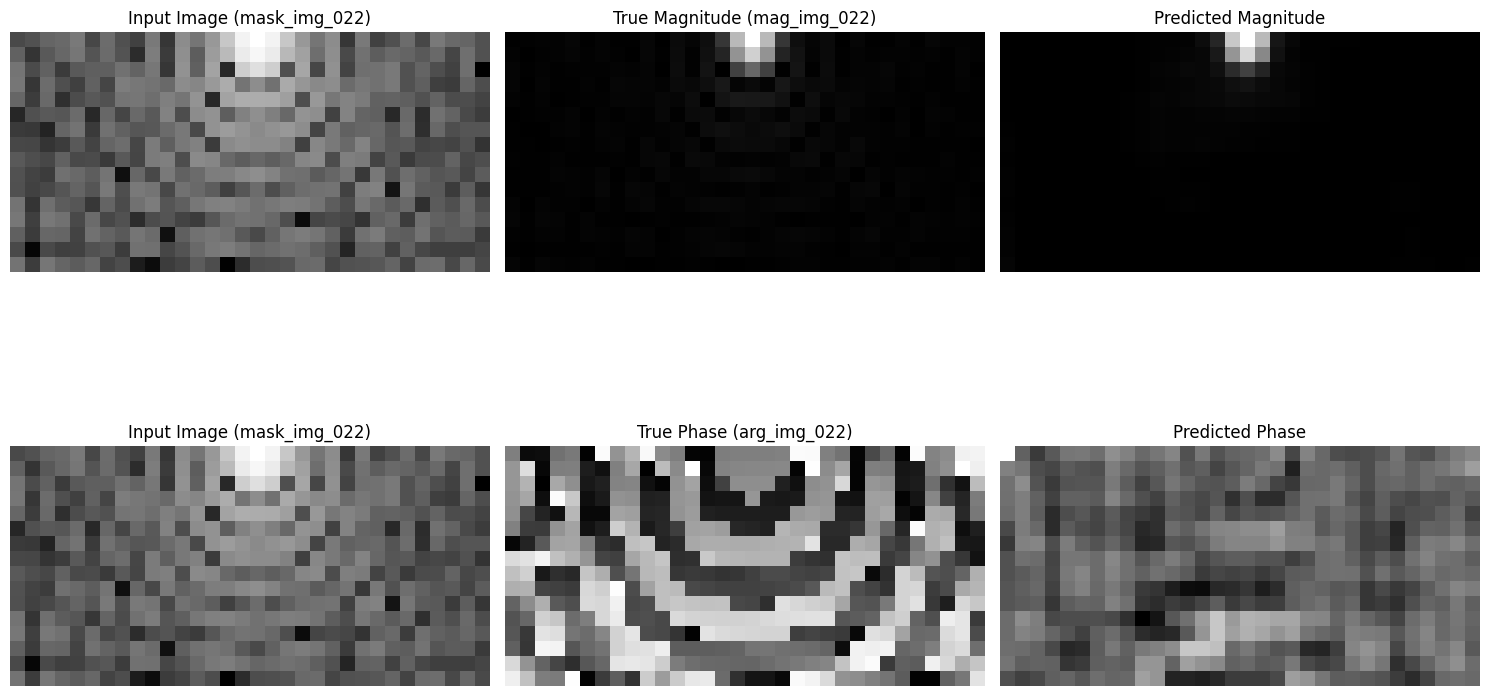

Reconstructed images saved to 'reconstructed_images' folder


In [5]:
import random

# Create folder for reconstructed images
os.makedirs('reconstructed_images', exist_ok=True)

# Load the trained model
model = tf.keras.models.load_model('mag_arg_autoencoder.h5', 
                                  custom_objects={'masked_mse': masked_mse(mask_value=0.0)})

# Function to load and preprocess a single image pair
def load_single_image_pair(idx, input_dir='input_images', target_dir='target_images'):
    # Load input image (masked data)
    input_img = np.array(Image.open(f'{input_dir}/mask_img_{idx:03d}.png')) / 255.0
    input_img = np.expand_dims(input_img, axis=(0, -1))  # Add batch and channel dim
    
    # Load target images
    mag_img = np.array(Image.open(f'{target_dir}/mag_img_{idx:03d}.png')) / 255.0
    arg_img = np.array(Image.open(f'{target_dir}/arg_img_{idx:03d}.png')) / 255.0
    
    return input_img, mag_img, arg_img

# Randomly select an image index
random_idx = 22 #random.randint(1, 100)
print(f"Selected image index: {random_idx:03d}")

# Load the selected images
input_img, true_mag, true_arg = load_single_image_pair(random_idx)

# Generate predictions
pred_mag, pred_arg = model.predict(input_img)

# Remove batch dimension and scale back to 0-255
pred_mag = (pred_mag[0,...,0] * 255).astype(np.uint8)
pred_arg = (pred_arg[0,...,0] * 255).astype(np.uint8)
true_mag = (true_mag * 255).astype(np.uint8)
true_arg = (true_arg * 255).astype(np.uint8)
input_img_display = (input_img[0,...,0] * 255).astype(np.uint8)

# Save reconstructed images
Image.fromarray(pred_mag).save(f'reconstructed_images/pred_mag_{random_idx:03d}.png')
Image.fromarray(pred_arg).save(f'reconstructed_images/pred_arg_{random_idx:03d}.png')

# Create comparison plot
plt.figure(figsize=(15, 10))

# Input image
plt.subplot(2, 3, 1)
plt.imshow(input_img_display, cmap='gray')
plt.title(f'Input Image (mask_img_{random_idx:03d})')
plt.axis('off')

# True magnitude
plt.subplot(2, 3, 2)
plt.imshow(true_mag, cmap='gray')
plt.title(f'True Magnitude (mag_img_{random_idx:03d})')
plt.axis('off')

# Predicted magnitude
plt.subplot(2, 3, 3)
plt.imshow(pred_mag, cmap='gray')
plt.title(f'Predicted Magnitude')
plt.axis('off')

# Input image (duplicate for layout)
plt.subplot(2, 3, 4)
plt.imshow(input_img_display, cmap='gray')
plt.title(f'Input Image (mask_img_{random_idx:03d})')
plt.axis('off')

# True phase
plt.subplot(2, 3, 5)
plt.imshow(true_arg, cmap='gray')
plt.title(f'True Phase (arg_img_{random_idx:03d})')
plt.axis('off')

# Predicted phase
plt.subplot(2, 3, 6)
plt.imshow(pred_arg, cmap='gray')
plt.title(f'Predicted Phase')
plt.axis('off')

plt.tight_layout()
plt.savefig(f'reconstructed_images/comparison_{random_idx:03d}.png')
plt.show()

print(f"Reconstructed images saved to 'reconstructed_images' folder")

### Compare reconstructed Images

Image data shape: (32, 32)


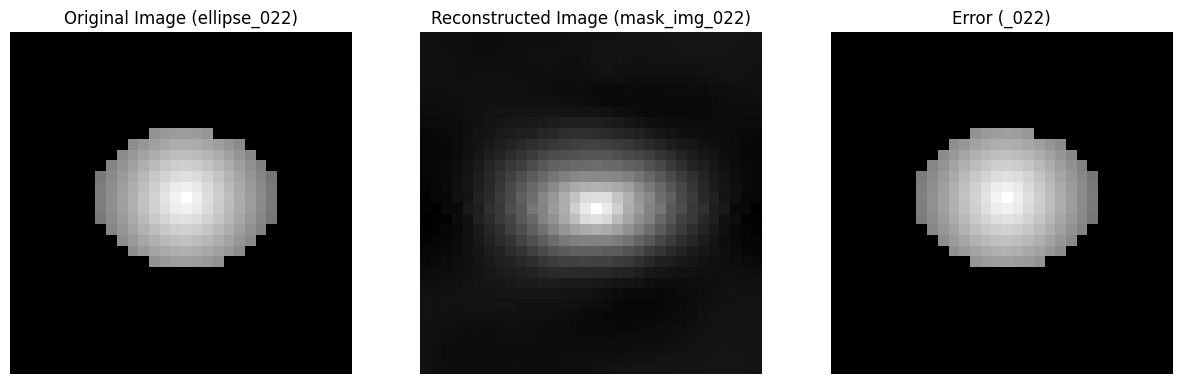

Comparison saved to 'image_comparison' folder


In [19]:
# Specify the image path
image_path = "org_images/ellipse_022.png"


# Open the image and load it into a variable
org_img = Image.open(image_path)


# Display the image (optional)


# If you need the image data as a NumPy array

org_img_data = np.array(org_img)

# Print the shape of the image array (optional)
print("Image data shape:", org_img_data.shape)

# Show Image

# plt.imshow(org_img_data, cmap="gray")
# plt.axis("off")
# plt.show()


# Inverse Fourier transformation

def inverse_fourier_image(mag, arg):
    # Load images
    mag_img = mag
    phase_img = arg
    
    # Convert magnitude from log scale back to linear
#     log_mag = mag_img.astype(float)/255 * (np.log(1e10)-np.log(1e-10)) + np.log(1e-10)
    mag_ft = mag_img
    
    # Convert phase from [0,255] to [-π,π]
#     phase_ft = (phase_img*2*np.pi)/255 - np.pi
    phase_ft = phase_img.astype(float)*2*np.pi/255 - np.pi
    # Reconstruct complex FT (lower half only)
    ft_half = mag_ft * np.exp(1j * phase_ft)
    ft_full = np.concatenate((np.conj(ft_half[::-1,:]), ft_half))
    
    recon = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(ft_full))).real
    
    return recon, mag_ft, phase_ft, ft_full


recon_img = inverse_fourier_image(pred_mag, pred_arg)[0]

error = org_img_data - recon_img

normalised = (org_img_data - recon_img)/np.max(error)*255

# Create comparison plot
plt.figure(figsize=(15, 10))

# Input image
plt.subplot(2, 3, 1)
plt.imshow(org_img_data, cmap='gray')
plt.title(f'Original Image (ellipse_{random_idx:03d})')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(recon_img, cmap='gray')
plt.title(f'Reconstructed Image (mask_img_{random_idx:03d})')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(normalised, cmap='gray')
plt.title(f'Error (_{random_idx:03d})')
plt.axis('off')


os.makedirs('image_comparison', exist_ok=True)
plt.savefig(f'image_comparison/comparison_{random_idx:03d}.png')

plt.show()

print(f"Comparison saved to 'image_comparison' folder")